# colab에서 한글 사용하기
- 아래 셀을 실행 -> 런타임 다시 시작 -> 한번 더 실행 -> 그래프 출력하기

In [ ]:
# colab에서 한글폰트 사용하기 
# 아래 셀을 실행 -> 런타임 다시 시작 -> 한번 더 실행 -> 그래프 출력하기
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


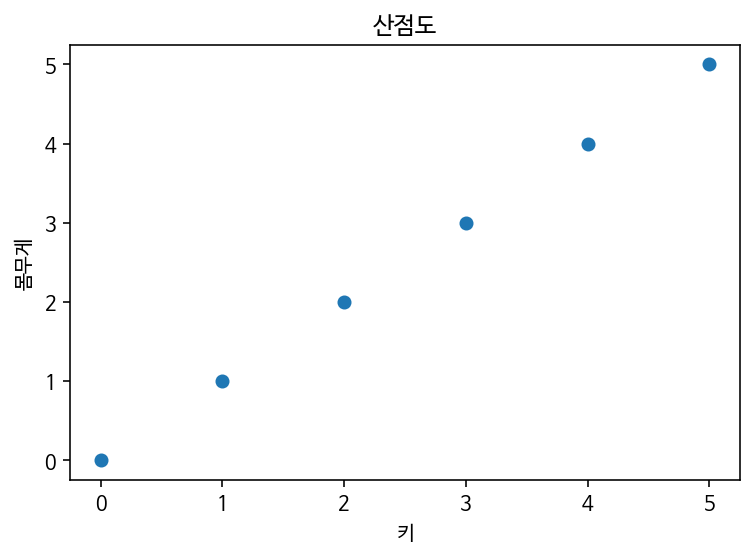

In [ ]:
# 한글 깨짐 테스트
plt.scatter([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.title('산점도')
plt.xlabel('키')
plt.ylabel('몸무게')
plt.show()

# **서울시 공공자전거(따릉이) 현황 분석**
- [따릉이 관련기사] : (https://www.hankookilbo.com/News/Read/A2022042715050005156)
- [따릉이 편리하게 이용하기 위한 14가지 | 서울시 정보소통광장](https://opengov.seoul.go.kr/mediahub/15085803)

# 1.데이터분석의 주제 선정
- 대여소그룹별(자치구) 자전거 대여건수 파악
- 대여건수가 많은 상위의 대여소 파악
- 월별 자전거 대여수 비교 분석
- 이동거리/평균사용시간이 높은 대여소 파악
- 요일별 연령대별 평균 사용시간 비교
- 구별 거치대 분포 현황(구별 설치 거치대 개수) 파악과 지도 시각화


# 2.데이터 수집
- 서울열린 데이터 광장 
- [따릉이데이터](https://data.seoul.go.kr/dataList/datasetList.do)
- Data1 : 서울특별시 공공자전거 대여소 정보
  - http://data.seoul.go.kr/dataList/OA-13252/F/1/datasetView.do
  - 파일 : 공공자전거 대여소 정보(21.06월 기준).xlsx
  - 대여소이름, 관리번호, 위치정보, 거치대수 정보제공
- Data2 : 서울특별시 공공자전거 대여소별 이용정보(월별)
  - http://data.seoul.go.kr/dataList/OA-15249/F/1/datasetView.do
  - 파일 : 공공자전거 대여소별 이용정보_21.02~21.06.csv
  - 서울특별시 공공자전거 대여소별 대여, 반납정보
  - 년월, 대여소번호, 대여소명, 대여건수, 반납건수
- Data3 : 서울특별시 공공자전거 이용정보(시간대별)
  - http://data.seoul.go.kr/dataList/OA-15245/F/1/datasetView.do
  - 다운로드 : 서울특별시 공공자전거 이용정보(시간대별)_2021년.zip
  - 파일 : 서울특별시 공공자전거 이용정보(시간대별)_21.06.csv
  - 대여일시, 대여시간, 대여소번호, 대여소명, 정기권유무, 성별, 연령대, 탄소량, 이동거리, 이동시간
 


## 2-1.구글 드라이브 마운트

In [ ]:
#구글 드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##2-2. 데이터 불러오기

In [ ]:
#데이터 불러오기
import pandas as pd
bk_df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/배포_2차수/dataset/자전거/공공자전거 대여소 정보(21.06월 기준).csv', encoding='cp949')
bk_df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/배포_2차수/dataset/자전거/공공자전거 대여소별 이용정보_21.02_21.06.csv' ,encoding='cp949')
bk_df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/배포_2차수/dataset/자전거/공공자전거 이용정보(시간대별)_21.06.csv',encoding='cp949')


In [ ]:
# 데이터 확인
bk_df1.head()

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,거치대수lcd,거치대수qr,운영방식
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,20.0,NaN,LCD
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,14.0,NaN,LCD
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,13.0,NaN,LCD
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,5.0,NaN,LCD
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,10.0,NaN,LCD


# 3.데이터 처리


## 3-1.데이터 미리보기 & 요약
- 데이터 미리보기 : df.head() , df.tail(), df.sample()
- 데이터 건수 확인 : df.shape 
- 데이터 컬럼,컬럼type 확인 : df.info()
- 데이터 분포 정보 : df.describe()

In [ ]:
#공공자전거 대여소 정보
bk_df1.tail()


,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,거치대수lcd,거치대수qr,운영방식
2462,4864,송파사거리,송파구,송파구 송파동 97-2,37.502056,127.110550,2021-04-27,NaN,6.0,QR
2463,4865,한성백제역 1번출구 뒤,송파구,송파구 방이동 45-4,37.516342,127.115593,2021-04-28,NaN,5.0,QR
2464,4867,가락대림아파트 앞,송파구,송파구 가락동 94-9,37.500027,127.118431,2021-04-28,NaN,10.0,QR
2465,4868,레이크 호텔 앞,송파구,송파구 석촌동 158,37.507172,127.101242,2021-05-18,NaN,7.0,QR
2466,4869,잠실나들목6,송파구,잠실동 24,37.516296,127.084610,2021-06-21,NaN,9.0,QR


In [ ]:
bk_df1.shape

(2467, 10)

In [ ]:
bk_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   대여소번호    2467 non-null   int64  
 1   대여소명     2467 non-null   object 
 2   자치구      2467 non-null   object 
 3   상세주소     2467 non-null   object 
 4   위도       2467 non-null   float64
 5   경도       2467 non-null   float64
 6   설치시기     2467 non-null   object 
 7   거치대수lcd  1454 non-null   float64
 8   거치대수qr   1014 non-null   float64
 9   운영방식     2467 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 192.9+ KB


- 대여소번호는 수치나 연속성을 나타내는 값이 아니기 때문에 전처리시 object타입으로 변경하겠습니다

### [Q1] 
bk_df2 대여소별 이용정보(월별) 전체 건수는?

In [ ]:
bk_df2.head()

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수
0,강남구,2301. 현대고등학교 건너편,202102.0,1713.0
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),202102.0,538.0
2,강남구,2303. 논현역 7번출구,202102.0,440.0
3,강남구,2304. 신영 ROYAL PALACE 앞,202102.0,156.0
4,강남구,2305. MCM 본사 직영점 앞,202102.0,197.0


In [ ]:
bk_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14749 entries, 0 to 14748
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   대여소 그룹     11776 non-null  object 
 1   대여소 명      11776 non-null  object 
 2   대여 일자 / 월  11776 non-null  float64
 3   대여 건수      11776 non-null  float64
dtypes: float64(2), object(2)
memory usage: 461.0+ KB


In [ ]:
bk_df2.shape

(14749, 4)

- 대여 일자/월 의 데이터타입이 float64를 string이나 날짜타입으로 변경하겠습니다

### [Q2] 
bk_df3 전체 건수는?

In [ ]:
bk_df3.shape

(2616598, 12)

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,~10대,1,8.75,0.08,350.53,3
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,~10대,1,54.31,0.49,2110.00,14
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,~10대,1,26.30,0.18,772.25,6
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,~10대,1,27.50,0.30,1285.82,5
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,~10대,1,42.46,0.46,1985.56,21


In [ ]:
bk_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616598 entries, 0 to 2616597
Data columns (total 12 columns):
 #   Column  Dtype  
---  ------  -----  
 0   대여일자    object 
 1   대여시간    int64  
 2   대여소번호   int64  
 3   대여소명    object 
 4   대여구분코드  object 
 5   성별      object 
 6   연령대코드   object 
 7   이용건수    int64  
 8   운동량     object 
 9   탄소량     object 
 10  이동거리    float64
 11  사용시간    int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 239.6+ MB


- 대여소번호를 object로 변환하겠습니다
- 운동량, 탄소량 은 수치형 데이터로 수치형타입으로 변경하겠습니다

## 3-2 대여소 정보(bk_df1)
- 분석내용 : 구별 거치대 분포 현황(구별 설치 총거치대 개수) 파악과 지도 시각화
- 총거치대수 = 거치대수lcd + 거치대수qr

### 3-2-1. 결측치 처리

In [ ]:
# 결측치 확인
bk_df1.isna().sum()

대여소번호         0
대여소명          0
자치구           0
상세주소          0
위도            0
경도            0
설치시기          0
거치대수lcd    1013
거치대수qr     1453
운영방식          0
dtype: int64

In [ ]:
# 전체건수를 확인
bk_df1.shape

(2467, 10)

In [ ]:
# 운영방식 종류 
bk_df1['운영방식'].value_counts()

LCD    1454
QR     1013
Name: 운영방식, dtype: int64

In [ ]:
# 거치대수lcd, 거치대수qr 컬럼에서 NaN은 0으로 처리
# fillna

bk_df1['거치대수lcd'] = bk_df1['거치대수lcd'].fillna(0)
bk_df1['거치대수qr']  = bk_df1['거치대수qr'].fillna(0)

In [ ]:
# 결측치 확인
bk_df1.isna().sum()

대여소번호      0
대여소명       0
자치구        0
상세주소       0
위도         0
경도         0
설치시기       0
거치대수lcd    0
거치대수qr     0
운영방식       0
dtype: int64

### 3-2-2 대여소번호 변환




In [ ]:
# 대여소번호 int64 -> object :  bk3 대여소번호     object     
 
bk_df1['대여소번호'] = bk_df1['대여소번호'].astype('object')

In [ ]:
bk_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   대여소번호    2467 non-null   object 
 1   대여소명     2467 non-null   object 
 2   자치구      2467 non-null   object 
 3   상세주소     2467 non-null   object 
 4   위도       2467 non-null   float64
 5   경도       2467 non-null   float64
 6   설치시기     2467 non-null   object 
 7   거치대수lcd  2467 non-null   float64
 8   거치대수qr   2467 non-null   float64
 9   운영방식     2467 non-null   object 
dtypes: float64(4), object(6)
memory usage: 192.9+ KB


## 3-3. 대여소별 이용정보(월별)(bk_df2)
- 대여소그룹별(자치구) 자전거 대여건수 파악
- 대여건수가 많은 상위의 대여소 파악
- 월별 자전거 대여수 비교 분석

In [ ]:
bk_df2.head()

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수
0,강남구,2301. 현대고등학교 건너편,202102.0,1713.0
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),202102.0,538.0
2,강남구,2303. 논현역 7번출구,202102.0,440.0
3,강남구,2304. 신영 ROYAL PALACE 앞,202102.0,156.0
4,강남구,2305. MCM 본사 직영점 앞,202102.0,197.0


### 3-3-1. 결측치 처리

In [ ]:
# 결측치 확인
bk_df2.isna().sum()

대여소 그룹       2973
대여소 명        2973
대여 일자 / 월    2973
대여 건수        2973
dtype: int64

In [ ]:
bk_df2.shape

(14749, 4)

In [ ]:
bk_df2.loc[ bk_df2['대여소 그룹'].isnull() ]

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수
11776,NaN,NaN,NaN,NaN
11777,NaN,NaN,NaN,NaN
11778,NaN,NaN,NaN,NaN
11779,NaN,NaN,NaN,NaN
11780,NaN,NaN,NaN,NaN
...,...,...,...,...
14744,NaN,NaN,NaN,NaN
14745,NaN,NaN,NaN,NaN
14746,NaN,NaN,NaN,NaN
14747,NaN,NaN,NaN,NaN


In [ ]:
# 결측치 삭제 

In [ ]:
bk_df2 = bk_df2.dropna()
bk_df2.isna().sum()

대여소 그룹       0
대여소 명        0
대여 일자 / 월    0
대여 건수        0
dtype: int64

In [ ]:
bk_df2.shape

(11776, 4)

### 3-3-2. 대여소번호와 대여소명 분리하기

In [ ]:
# 2. bk_df2 대여소번호.대여소명 처리
# expand=True를 넣으면 바로 데이터프레임의 컬럼으로 생성이 된다
bk_df2['대여소번호'] = bk_df2['대여소 명'].str.split(".", expand=True)[0]
bk_df2['대여소명_new'] = bk_df2['대여소 명'].str.split(".",expand=True)[1]

In [ ]:
bk_df2.head()

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수,대여소번호,대여소명_new
0,강남구,2301. 현대고등학교 건너편,202102.0,1713.0,2301,현대고등학교 건너편
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),202102.0,538.0,2302,교보타워 버스정류장(신논현역 3번출구 후면)
2,강남구,2303. 논현역 7번출구,202102.0,440.0,2303,논현역 7번출구
3,강남구,2304. 신영 ROYAL PALACE 앞,202102.0,156.0,2304,신영 ROYAL PALACE 앞
4,강남구,2305. MCM 본사 직영점 앞,202102.0,197.0,2305,MCM 본사 직영점 앞


In [ ]:
bk_df2.isnull().sum()

대여소 그룹        0
대여소 명         0
대여 일자 / 월     0
대여 건수         0
대여소번호         0
대여소명_new     29
dtype: int64

In [ ]:
bk_df2.loc[ bk_df2['대여소명_new'].isnull() ]
#대여소 명에 대여소번호(숫자)없거나 NaN인 데이터 존재

,대여소 그룹,대여소 명,대여 일자 / 월,대여 건수,대여소번호,대여소명_new
1980,정비센터,상담센터,202102.0,32.0,상담센터,None
1981,정비센터,상암센터 정비실,202102.0,8.0,상암센터 정비실,None
1982,정비센터,위트콤,202102.0,375.0,위트콤,None
1983,정비센터,중랑센터,202102.0,16.0,중랑센터,None
2234,그룹명 없음,대여소명 없음,202102.0,1.0,대여소명 없음,None
4259,정비센터,사대문센터,202103.0,4.0,사대문센터,None
4260,정비센터,상담센터,202103.0,108.0,상담센터,None
4261,정비센터,상암센터 정비실,202103.0,3.0,상암센터 정비실,None
4262,정비센터,위트콤,202103.0,523.0,위트콤,None
4263,정비센터,중랑센터,202103.0,16.0,중랑센터,None


In [ ]:
#실제 대여소와 관련이 없으므로 삭제
# dropna(subset=컬럼명)
bk_df2 = bk_df2.dropna(subset=['대여소명_new'])

In [ ]:
bk_df2.isnull().sum()

대여소 그룹       0
대여소 명        0
대여 일자 / 월    0
대여 건수        0
대여소번호        0
대여소명_new     0
dtype: int64

In [ ]:
bk_df2['대여소 그룹'].value_counts()

송파구     877
강서구     790
서초구     666
강남구     661
영등포구    591
마포구     528
종로구     521
노원구     520
강동구     475
구로구     458
양천구     451
은평구     435
중구      418
동대문구    415
광진구     412
성동구     408
용산구     400
중랑구     387
성북구     370
서대문구    368
관악구     340
동작구     337
도봉구     310
강북구     299
금천구     295
정비센터     15
Name: 대여소 그룹, dtype: int64

### 3-3-3. 컬럼명 변경

In [ ]:
# 컬럼명 변경 (띄어쓰기 불편)
bk_df2.columns = ['대여소그룹','대여소명','대여일자/월','대여건수','대여소번호','대여소명_new']

In [ ]:
bk_df2.columns

Index(['대여소그룹', '대여소명', '대여일자/월', '대여건수', '대여소번호', '대여소명_new'], dtype='object')

### 3-3-4. 대여일자/월 변환

In [ ]:
# 4. 대여일자/월 datatype float->str로 변환
bk_df2['대여일자/월'] = bk_df2['대여일자/월'].astype(str)
bk_df2['대여일자/월'].value_counts()

202106.0    2465
202105.0    2394
202104.0    2365
202103.0    2293
202102.0    2230
Name: 대여일자/월, dtype: int64

In [ ]:
bk_df2['대여일자/월'] = bk_df2['대여일자/월'].str[:6]
bk_df2['대여일자/월'].value_counts()

202106    2465
202105    2394
202104    2365
202103    2293
202102    2230
Name: 대여일자/월, dtype: int64

## 3-4. 시간대별 이용정보 (bk_df3)
- 이동거리/평균사용시간이 높은 대여소 파악
- 요일별 연령대별 평균 사용시간 비교

[ 미리보기에서 전처리 결정사항 ]
- 대여소번호를 object로 변환하겠습니다
- 운동량, 탄소량 은 수치형 데이터로 수치형타입으로 변경하겠습니다
- 1) 결측치   2) 이상치

In [ ]:
# 전체건수
bk_df3.shape

(2616598, 12)

### 3-4-1. 결측치 처리

In [ ]:
# 1. 결측치 처리 
bk_df3.isnull().sum()

대여일자            0
대여시간            0
대여소번호           0
대여소명            0
대여구분코드          0
성별        1151099
연령대코드           0
이용건수            0
운동량             0
탄소량             0
이동거리            0
사용시간            0
dtype: int64

In [ ]:
bk_df3['성별'].value_counts()

M    871251
F    593525
m       502
f       221
Name: 성별, dtype: int64

In [ ]:
# 성별 구분 유일한 값
bk_df3['성별'].unique()


array([nan, 'F', 'M', 'm', 'f'], dtype=object)

- 대소문자가 섞여있으므로 대문자로 통일
- nan 값은 성별로 변경하기 어렵기 때문에 그대로 사용

In [ ]:
#성별 f==> F로 변경
bk_df3.loc[bk_df3['성별']=='f','성별'] = 'F'

In [ ]:
#[실습]성별 m ==> M로 변경

bk_df3.loc[bk_df3['성별']=='m','성별'] = 'M'


In [ ]:
# 성별 구분 유일한 값

bk_df3['성별'].unique()

array([nan, 'F', 'M'], dtype=object)

###3-4-2. 이상치 확인

In [ ]:
# 이동거리, 사용시간 이상치 확인 

bk_df3.describe().round()


,대여시간,대여소번호,이용건수,이동거리,사용시간
count,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0
mean,15.0,1697.0,1.0,3365.0,28.0
std,6.0,1248.0,0.0,5222.0,33.0
min,0.0,3.0,1.0,0.0,0.0
25%,10.0,678.0,1.0,940.0,8.0
50%,16.0,1369.0,1.0,1890.0,16.0
75%,19.0,2410.0,1.0,4018.0,38.0
max,23.0,99997.0,20.0,4731984.0,1527.0


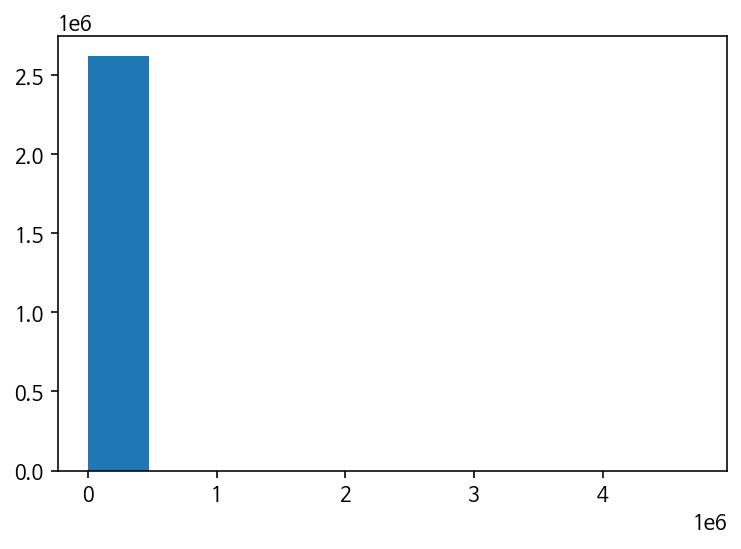

In [ ]:
# [실습] 이동거리에 대해 히스토그램으로 이상치 파악 
import matplotlib.pyplot as plt

plt.hist(bk_df3['이동거리'])
plt.show()

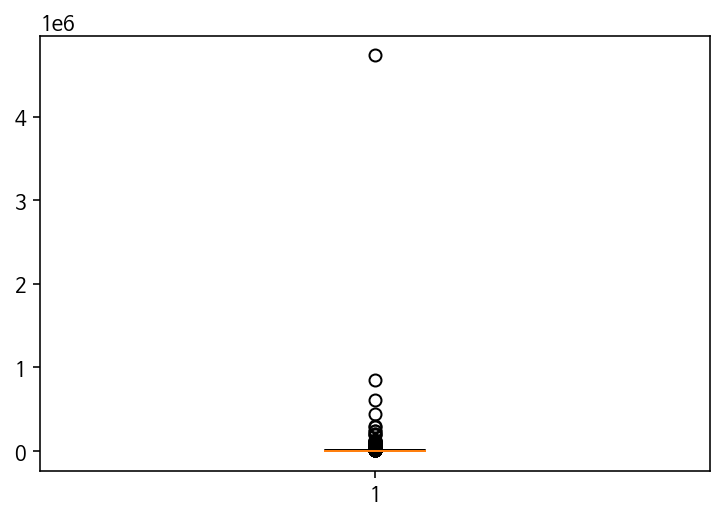

In [ ]:
# [실습] 이동거리에 대해 box 프롯을 그리시오
plt.boxplot(bk_df3['이동거리'])
plt.show()

In [ ]:
# IQR 활용한 이상치 함수 구현
import numpy as np

def outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    return data[(data > upper_bound) | (data < lower_bound)].index

In [ ]:
# '이동거리' 컬럼 값 기준으로 이상치 찾기
outliers = outliers_iqr( bk_df3['이동거리'] )
outliers

Int64Index([     24,      69,      81,      89,      99,     121,     130,
                141,     168,     194,
            ...
            2616458, 2616467, 2616473, 2616484, 2616486, 2616496, 2616500,
            2616528, 2616554, 2616555],
           dtype='int64', length=239170)

In [ ]:
# outliers 의 개수는?
len(outliers)/bk_df3.shape[0]*100

9.140494642279785

In [ ]:
# outliers 의 인덱스 값 이용하여 행 조회
bk_df3.loc[outliers]

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
24,2021-06-01,0,108,108. 서교동 사거리,정기권,NaN,20대,1,248.89,2.24,9669.35,68
69,2021-06-01,0,1180,1180. 마곡엠밸리 15단지(1502동) 건너편,정기권,NaN,20대,1,264.48,2.58,11131.32,53
81,2021-06-01,0,2183,2183. 동방1교,정기권,NaN,20대,1,239.82,2.13,9175.91,51
89,2021-06-01,0,766,766. 신목동역 3번출구,정기권,NaN,20대,2,236.56,2.13,9190.29,66
99,2021-06-01,0,299,299.여의도 순복음교회,정기권,NaN,20대,1,657.05,5.50,23703.07,137
...,...,...,...,...,...,...,...,...,...,...,...,...
2616496,2021-06-30,22,1655,1655. 공릉1단지아파트,정기권,M,50대,1,274.67,2.01,8670.00,105
2616500,2021-06-30,22,1983,1983. 구로동롯데아파트,정기권,M,50대,1,218.49,2.61,11260.00,119
2616528,2021-06-30,22,4852,4852. 서울복합물류 게이트 1,정기권,M,50대,1,256.89,2.32,9980.00,122
2616554,2021-06-30,22,1529,1529. 미아동 한국전력공사,정기권,M,60대,1,307.08,2.65,11403.57,107


In [ ]:
# 이상치 존재하는 행 제거
bk_df4 = bk_df3.drop(outliers)

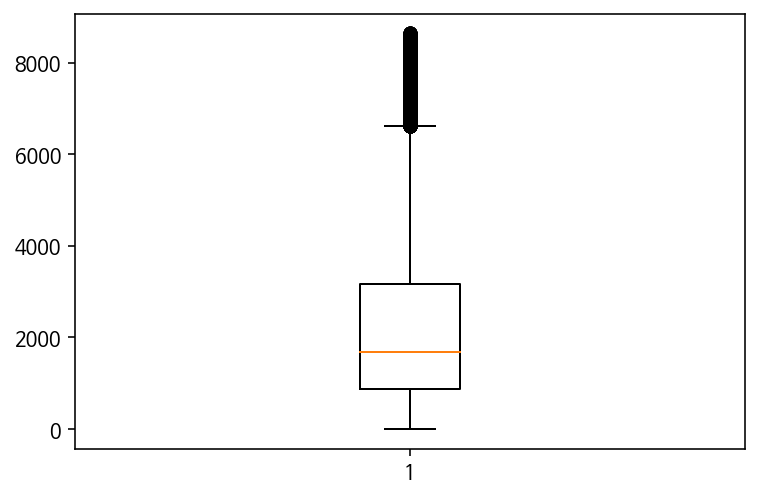

In [ ]:
# boxplot 
plt.boxplot(bk_df4['이동거리'])
plt.show()

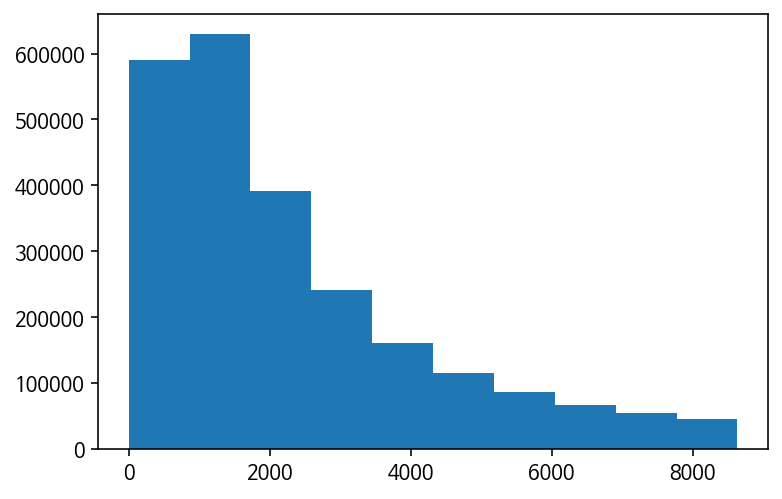

In [ ]:
# histogram 

plt.hist(bk_df4['이동거리'])
plt.show()

In [ ]:
# 왜도 확인
bk_df4['이동거리'].skew()

1.230418391121317

In [ ]:
bk_df3['이동거리'].skew()

288.29950016625764

In [ ]:
# 첨도 확인
bk_df4['이동거리'].kurt()

0.9148974357153259

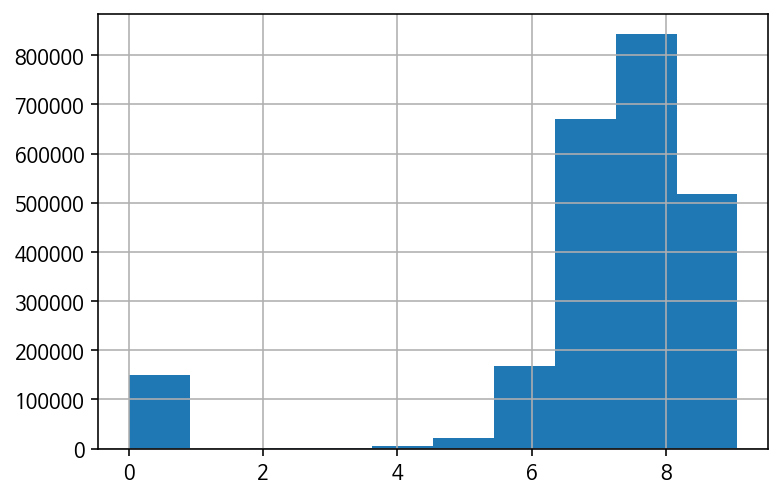

In [ ]:
# 정규분포를 만들기 위해 로그 변환
y_log = np.log1p(bk_df4['이동거리'])
y_log.hist()

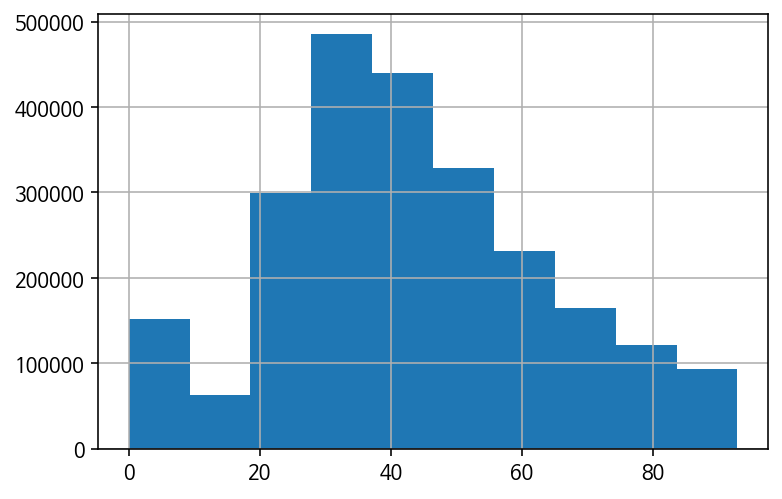

In [ ]:
y_sqrt = np.sqrt(bk_df4['이동거리'])
y_sqrt.hist()

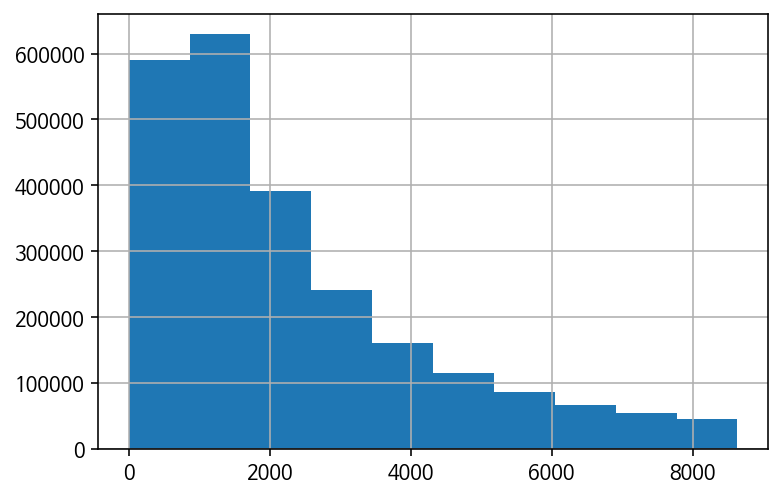

In [ ]:
# 역변환 
y_square = np.square(y_sqrt)
y_square.hist()

### 3-4-3. 연령대코드 처리

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,~10대,1,8.75,0.08,350.53,3
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,~10대,1,54.31,0.49,2110.00,14
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,~10대,1,26.30,0.18,772.25,6
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,~10대,1,27.50,0.30,1285.82,5
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,~10대,1,42.46,0.46,1985.56,21


In [ ]:
bk_df3['연령대코드'].value_counts()

20대     1070985
30대      665743
40대      408670
50대      257505
~10대     133963
60대       69759
70대~       9973
Name: 연령대코드, dtype: int64

In [ ]:
bk_df3.loc[bk_df3['연령대코드'] == '~10대','연령대코드'] = '10대'
bk_df3.loc[bk_df3['연령대코드'] == '70대~','연령대코드'] = '70대'

In [ ]:
bk_df3['연령대코드'].value_counts()

20대    1070985
30대     665743
40대     408670
50대     257505
10대     133963
60대      69759
70대       9973
Name: 연령대코드, dtype: int64

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,10대,1,8.75,0.08,350.53,3
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,10대,1,54.31,0.49,2110.00,14
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,10대,1,26.30,0.18,772.25,6
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,10대,1,27.50,0.30,1285.82,5
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,10대,1,42.46,0.46,1985.56,21


In [ ]:
bk_df1.head()

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,거치대수lcd,거치대수qr,운영방식
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,20.0,0.0,LCD
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,14.0,0.0,LCD
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,13.0,0.0,LCD
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,5.0,0.0,LCD
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,10.0,0.0,LCD


### 3-4-4. 대여소번호와 대여소명 분리하기
- bk_df3에서 대여소명에서 숫자와 주소 분리하기 , 대여소명_new 추가
- bk_df2 에도 동일 작업, 대여소번호, 대여소명_new  추가


In [ ]:
#split함수에서 expend=True 옵션을 사용하여 새로운 데이터프레임 만들기
bk_df3['대여소명'].str.split(".", expand=True).head()

,0,1,2,3
0,2169,봉천역 2번출구,None,None
1,1450,화랑대역 7번출구,None,None
2,1282,송파소방서 맞은편(성내4교),None,None
3,1288,문정중교 사거리,None,None
4,1737,하나은행 (창동점),None,None


In [ ]:
bk_df3['대여소명'].str.split(".")

0                 [2169,  봉천역 2번출구]
1                [1450,  화랑대역 7번출구]
2          [1282,  송파소방서 맞은편(성내4교)]
3                 [1288,  문정중교 사거리]
4               [1737,  하나은행 (창동점)]
                     ...           
2616593          [1640,  한내근린공원 북측]
2616594           [250,  대림아파트 사거리]
2616595      [1195,  코오롱One&Only타워]
2616596          [372,  약수역 3번출구 뒤]
2616597              [1044,  굽은다리역]
Name: 대여소명, Length: 2616598, dtype: object

In [ ]:
bk_df3['대여소명_new'] = bk_df3['대여소명'].str.split(".",expand=True)[1]

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여소명_new
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,10대,1,8.75,0.08,350.53,3,봉천역 2번출구
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,10대,1,54.31,0.49,2110.00,14,화랑대역 7번출구
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,10대,1,26.30,0.18,772.25,6,송파소방서 맞은편(성내4교)
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,10대,1,27.50,0.30,1285.82,5,문정중교 사거리
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,10대,1,42.46,0.46,1985.56,21,하나은행 (창동점)


In [ ]:
bk_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2616598 entries, 0 to 2616597
Data columns (total 13 columns):
 #   Column    Dtype  
---  ------    -----  
 0   대여일자      object 
 1   대여시간      int64  
 2   대여소번호     int64  
 3   대여소명      object 
 4   대여구분코드    object 
 5   성별        object 
 6   연령대코드     object 
 7   이용건수      int64  
 8   운동량       object 
 9   탄소량       object 
 10  이동거리      float64
 11  사용시간      int64  
 12  대여소명_new  object 
dtypes: float64(1), int64(4), object(8)
memory usage: 259.5+ MB


### 3-4-5. 데이터타입 변환

- bk_df3의 대여소번호를 문자형으로

In [ ]:
bk_df3['대여소번호'] = bk_df3['대여소번호'].astype(object)

- bk_df3의 대여일자를 datetime으로

In [ ]:
#대여일자로 년, 월, 일, 요일 컬럼을 생성한다
bk_df3['대여일자'] = pd.to_datetime(bk_df3['대여일자'])
bk_df3['년도'] = bk_df3['대여일자'].dt.year
bk_df3['월'] = bk_df3['대여일자'].dt.month
bk_df3['일'] = bk_df3['대여일자'].dt.day
bk_df3['요일(num)']=bk_df3['대여일자'].dt.dayofweek

In [ ]:
weekday_map= {0:'월', 1:'화', 2:'수', 3:'목',
              4:'금', 5:'토', 6:'일'}
bk_df3['요일'] = bk_df3['요일(num)'].map(weekday_map)

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여소명_new,년도,월,일,요일(num),요일
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,10대,1,8.75,0.08,350.53,3,봉천역 2번출구,2021,6,1,1,화
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,10대,1,54.31,0.49,2110.00,14,화랑대역 7번출구,2021,6,1,1,화
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,10대,1,26.30,0.18,772.25,6,송파소방서 맞은편(성내4교),2021,6,1,1,화
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,10대,1,27.50,0.30,1285.82,5,문정중교 사거리,2021,6,1,1,화
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,10대,1,42.46,0.46,1985.56,21,하나은행 (창동점),2021,6,1,1,화


In [ ]:
##################  여기까지 했습니다!! 

- bk_df3의 운동량, 탄소량을 숫자형으로

In [ ]:
bk_df3['운동량'] = bk_df3['운동량'].astype(float)
bk_df3['탄소량'] = bk_df3['탄소량'].astype(float)

ValueError: ignored

In [ ]:
# 에러확인 
bk_df3 [ bk_df3['운동량'] =='\\N' ]


,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여소명_new,년도,월,일,요일(num),요일
39,2021-06-01,0,3511,3511. 응봉역 1번출구,정기권,NaN,20대,1,\N,\N,0.0,42,응봉역 1번출구,2021,6,1,1,화
330,2021-06-01,0,1464,1464.중화역 4번출구,정기권,NaN,40대,1,\N,\N,0.0,52,중화역 4번출구,2021,6,1,1,화
478,2021-06-01,0,1167,1167. 마곡수명산파크3단지 교차로,정기권,F,20대,1,\N,\N,0.0,20,마곡수명산파크3단지 교차로,2021,6,1,1,화
774,2021-06-01,0,2396,2396. 영동3교 북단(우성캐릭터 앞 보도),정기권,M,30대,1,\N,\N,0.0,15,영동3교 북단(우성캐릭터 앞 보도),2021,6,1,1,화
877,2021-06-01,0,250,250. 대림아파트 사거리,정기권,M,40대,1,\N,\N,0.0,56,대림아파트 사거리,2021,6,1,1,화
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616452,2021-06-30,22,2187,2187.현대시장사거리(신한은행),정기권,M,40대,1,\N,\N,0.0,119,현대시장사거리(신한은행),2021,6,30,2,수
2616487,2021-06-30,22,2331,2331. 동영문화센터앞,정기권,M,40대,1,\N,\N,0.0,122,동영문화센터앞,2021,6,30,2,수
2616564,2021-06-30,22,3787,3787. 가양나들목,정기권,M,70대,1,\N,\N,0.0,113,가양나들목,2021,6,30,2,수
2616590,2021-06-30,23,348,348. 독립문역 사거리,정기권,NaN,20대,1,\N,\N,0.0,9,독립문역 사거리,2021,6,30,2,수


In [ ]:
# 값 보정
bk_df3.loc[bk_df3['운동량']== '\\N','운동량'] = -1
bk_df3.loc[bk_df3['탄소량']== '\\N','탄소량'] = -1

In [ ]:
bk_df3.loc[bk_df3['운동량']== '\\N']

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여소명_new,년도,월,일,요일(num),요일


In [ ]:
# 숫자로 변환
bk_df3['운동량'] = pd.to_numeric(bk_df3['운동량'])
bk_df3['탄소량'] = pd.to_numeric(bk_df3['탄소량'])

In [ ]:
#연속형(수치) 데이터의 통계치 확인하기
bk_df3.describe().round()

,대여시간,이용건수,운동량,탄소량,이동거리,사용시간,년도,월,일,요일(num)
count,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0
mean,15.0,1.0,388.0,1.0,3365.0,28.0,2021.0,6.0,16.0,3.0
std,6.0,0.0,167156.0,1.0,5222.0,33.0,0.0,0.0,9.0,2.0
min,0.0,1.0,-1.0,-1.0,0.0,0.0,2021.0,6.0,1.0,0.0
25%,10.0,1.0,24.0,0.0,940.0,8.0,2021.0,6.0,8.0,1.0
50%,16.0,1.0,49.0,0.0,1890.0,16.0,2021.0,6.0,16.0,3.0
75%,19.0,1.0,105.0,1.0,4018.0,38.0,2021.0,6.0,23.0,5.0
max,23.0,20.0,100000000.0,1098.0,4731984.0,1527.0,2021.0,6.0,30.0,6.0


# 4.EDA & Visualization

## 4-1.대여소그룹별 대여건수

In [ ]:
bk_df2.columns

Index(['대여소그룹', '대여소명', '대여일자/월', '대여건수', '대여소번호', '대여소명_new'], dtype='object')

In [ ]:
bk_df2.head()

,대여소그룹,대여소명,대여일자/월,대여건수,대여소번호,대여소명_new
0,강남구,2301. 현대고등학교 건너편,202102,1713.0,2301,현대고등학교 건너편
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),202102,538.0,2302,교보타워 버스정류장(신논현역 3번출구 후면)
2,강남구,2303. 논현역 7번출구,202102,440.0,2303,논현역 7번출구
3,강남구,2304. 신영 ROYAL PALACE 앞,202102,156.0,2304,신영 ROYAL PALACE 앞
4,강남구,2305. MCM 본사 직영점 앞,202102,197.0,2305,MCM 본사 직영점 앞


In [ ]:
bk_df2.info()

In [ ]:
# 대여소그룹별 대여건수의 합

df = bk_df2.groupby('대여소그룹')['대여건수'].sum()
df

In [ ]:
df = df.reset_index()
df

In [ ]:
# 상위 20개 대여소그룹 
df = df.sort_values('대여건수', ascending=False)

In [ ]:
# 대여건수가 많은 상위10개 대여소그룹 저장, 월별대여건수 시각화에서 10개 구만 사용
gu_lst = df['대여소그룹'][:10]
gu_lst = list(gu_lst.values)
gu_lst

['강서구', '송파구', '영등포구', '마포구', '노원구', '양천구', '광진구', '성동구', '구로구', '동대문구']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

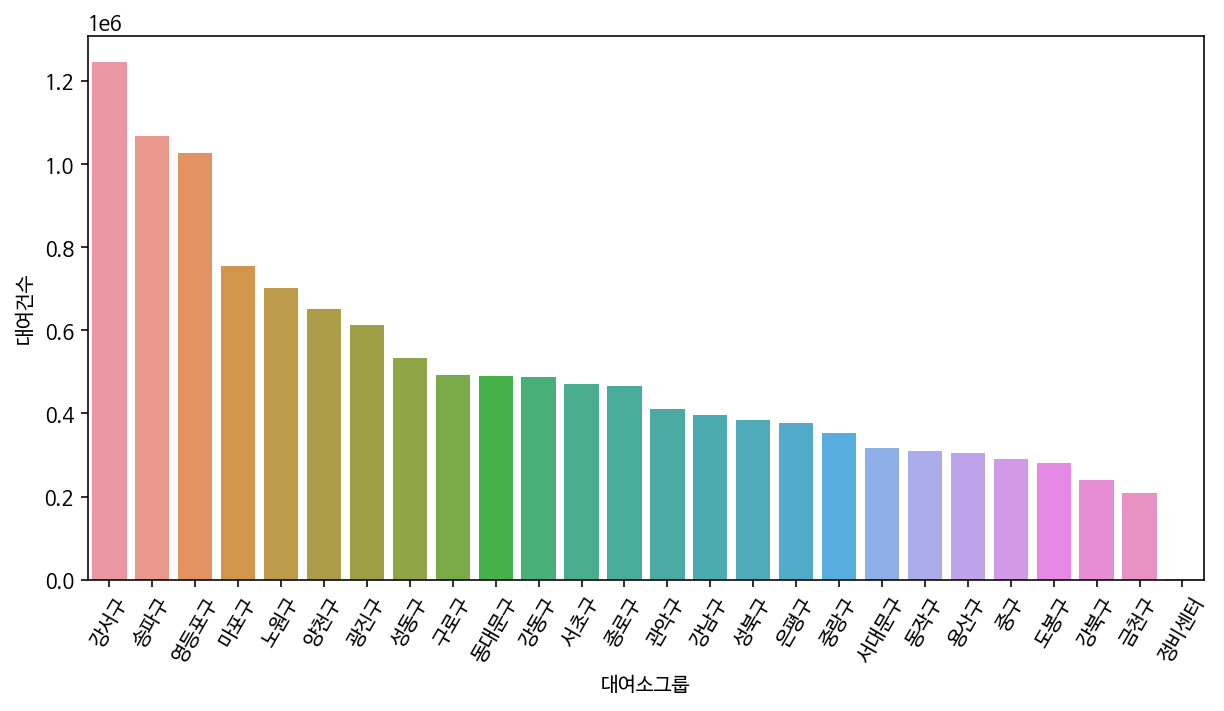

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x= df['대여소그룹'], y=df['대여건수'])
plt.xticks(rotation = 60)

## 4-2.대여건수가 많은 상위 대여소

In [ ]:
bk_df2.columns

Index(['대여소그룹', '대여소명', '대여일자/월', '대여건수', '대여소번호', '대여소명_new'], dtype='object')

In [ ]:
bk_df2.head()

,대여소그룹,대여소명,대여일자/월,대여건수,대여소번호,대여소명_new
0,강남구,2301. 현대고등학교 건너편,202102,1713.0,2301,현대고등학교 건너편
1,강남구,2302. 교보타워 버스정류장(신논현역 3번출구 후면),202102,538.0,2302,교보타워 버스정류장(신논현역 3번출구 후면)
2,강남구,2303. 논현역 7번출구,202102,440.0,2303,논현역 7번출구
3,강남구,2304. 신영 ROYAL PALACE 앞,202102,156.0,2304,신영 ROYAL PALACE 앞
4,강남구,2305. MCM 본사 직영점 앞,202102,197.0,2305,MCM 본사 직영점 앞


In [ ]:
#[실습] 대여건수가 많은 상위20개 대여소
df = bk_df2.groupby('대여소명_new')['대여건수'].sum()
df = df.reset_index()
df = df.sort_values('대여건수', ascending=False)[:20]
df

,대여소명_new,대여건수
1319,여의나루역 1번출구 앞,66958.0
579,뚝섬유원지역 1번출구 앞,66427.0
644,마포구민체육센터 앞,41814.0
813,봉림교 교통섬,41286.0
593,롯데월드타워(잠실역2번출구 쪽),35293.0
2089,마곡나루역 2번 출구,35143.0
444,당산육갑문,30487.0
1175,신대방역 2번 출구,30312.0
16,IFC몰,30082.0
1397,옥수역 3번출구,28317.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

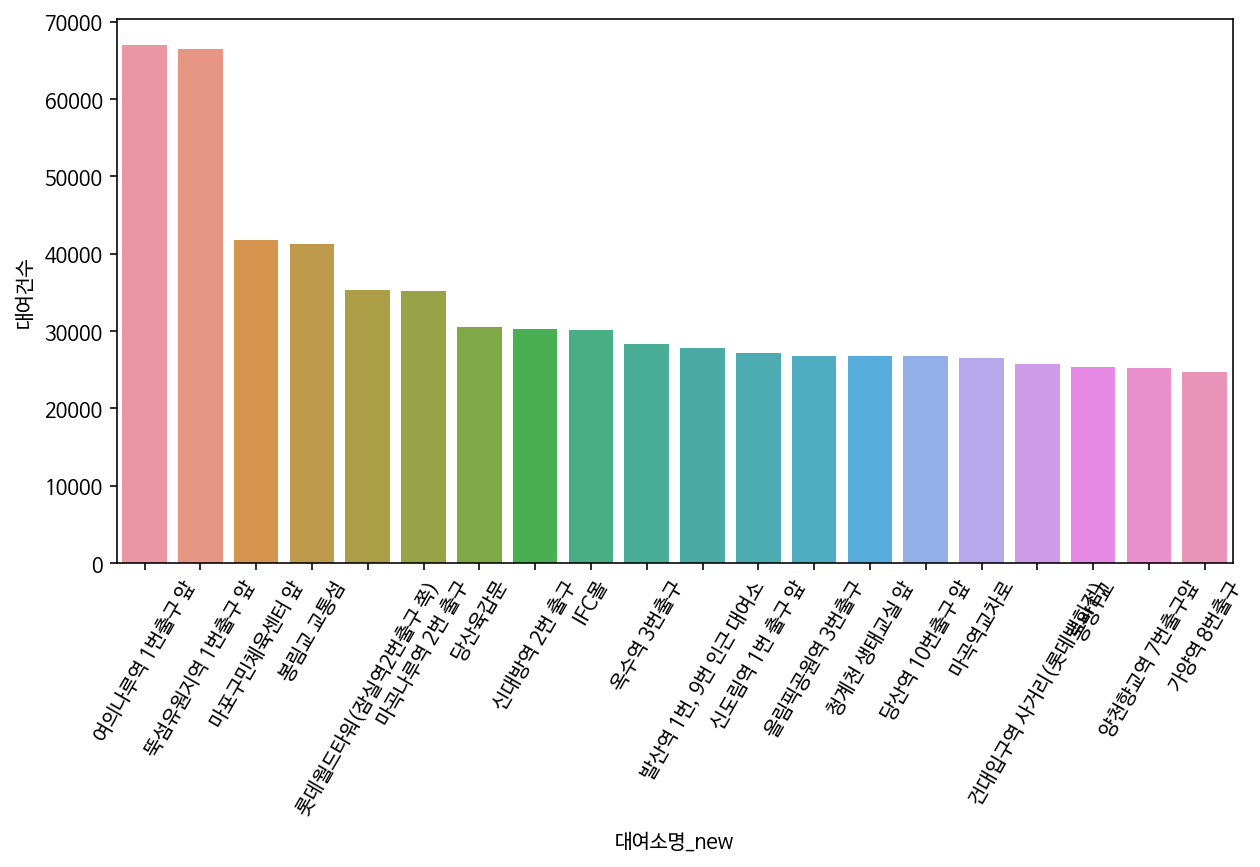

In [ ]:
# barplot 1
plt.figure(figsize=(10,5))
sns.barplot(x= df['대여소명_new'], y=df['대여건수'])
plt.xticks(rotation = 60)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

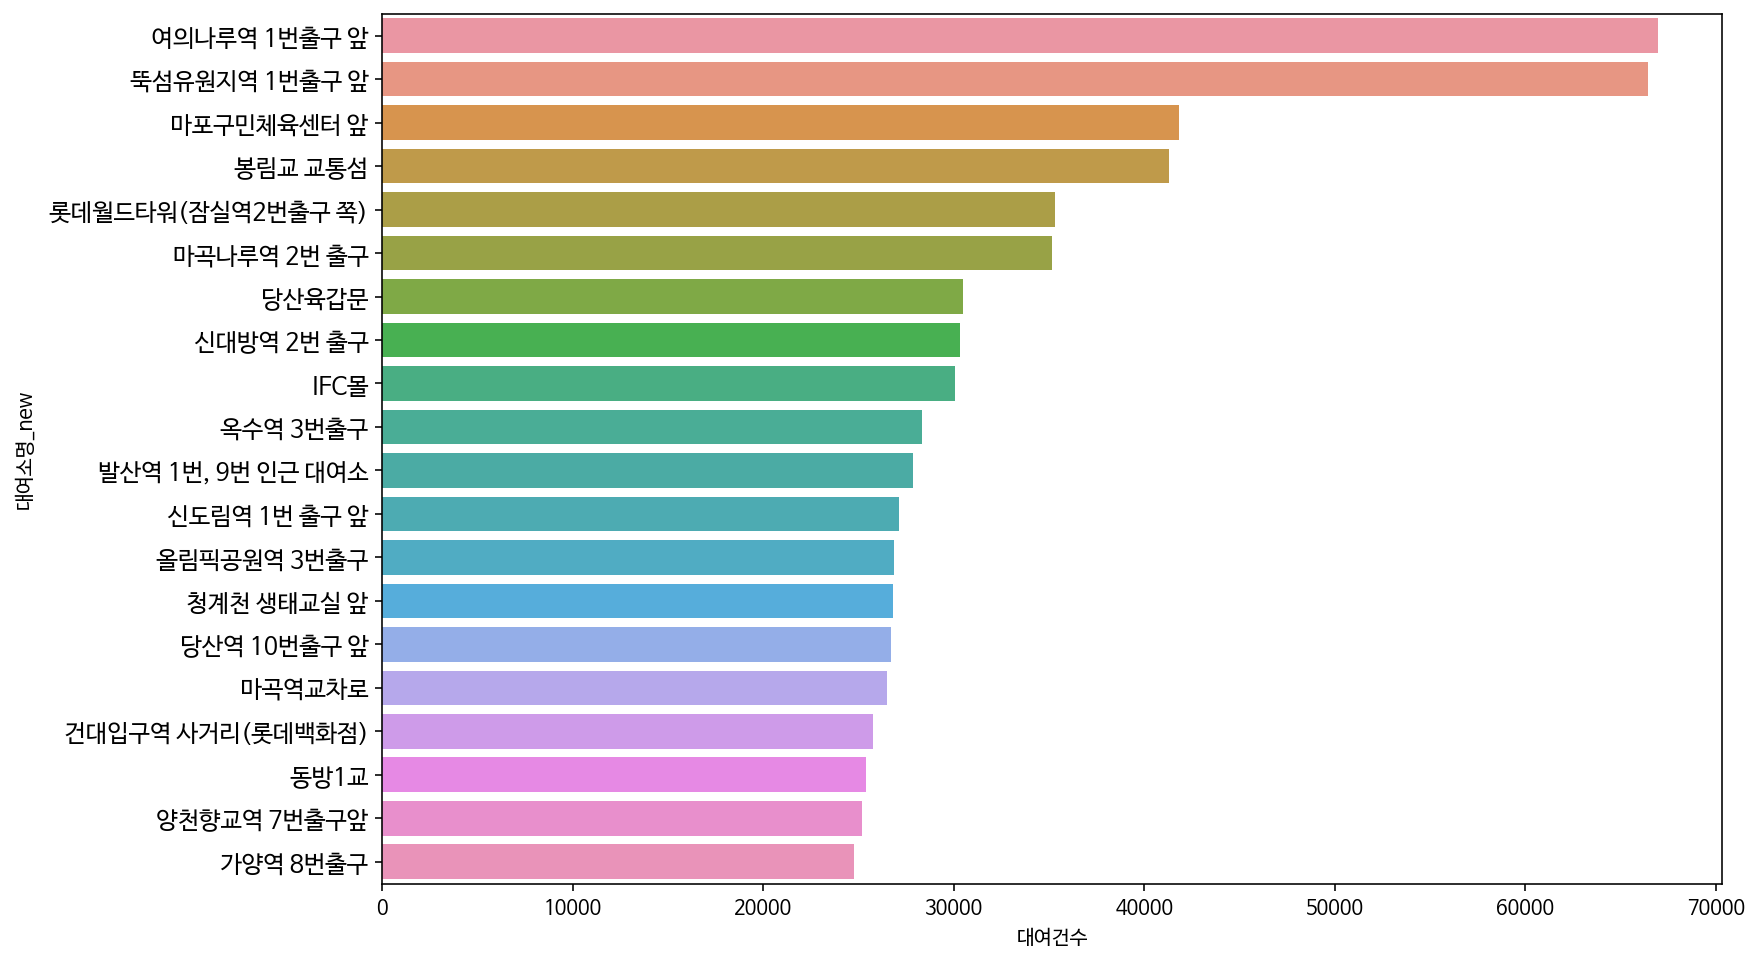

In [ ]:
# barplot 2
plt.figure(figsize=(12,8))
sns.barplot(x=df['대여건수'] , y= df['대여소명_new'])
plt.yticks(fontsize=12)


##4-3.월별,대여소그룹별 대여건수

In [ ]:
#대여건수 상위 10개 구의 월별 대여량
df = bk_df2.groupby(['대여일자/월','대여소그룹'])[['대여건수']].sum()
df = df.reset_index()
df = df.loc[df['대여소그룹'].isin(gu_lst)]
df

,대여일자/월,대여소그룹,대여건수
3,202102,강서구,108020.0
5,202102,광진구,62781.0
6,202102,구로구,46909.0
8,202102,노원구,61549.0
10,202102,동대문구,48842.0
12,202102,마포구,75510.0
15,202102,성동구,57634.0
17,202102,송파구,95663.0
18,202102,양천구,61853.0
19,202102,영등포구,103026.0


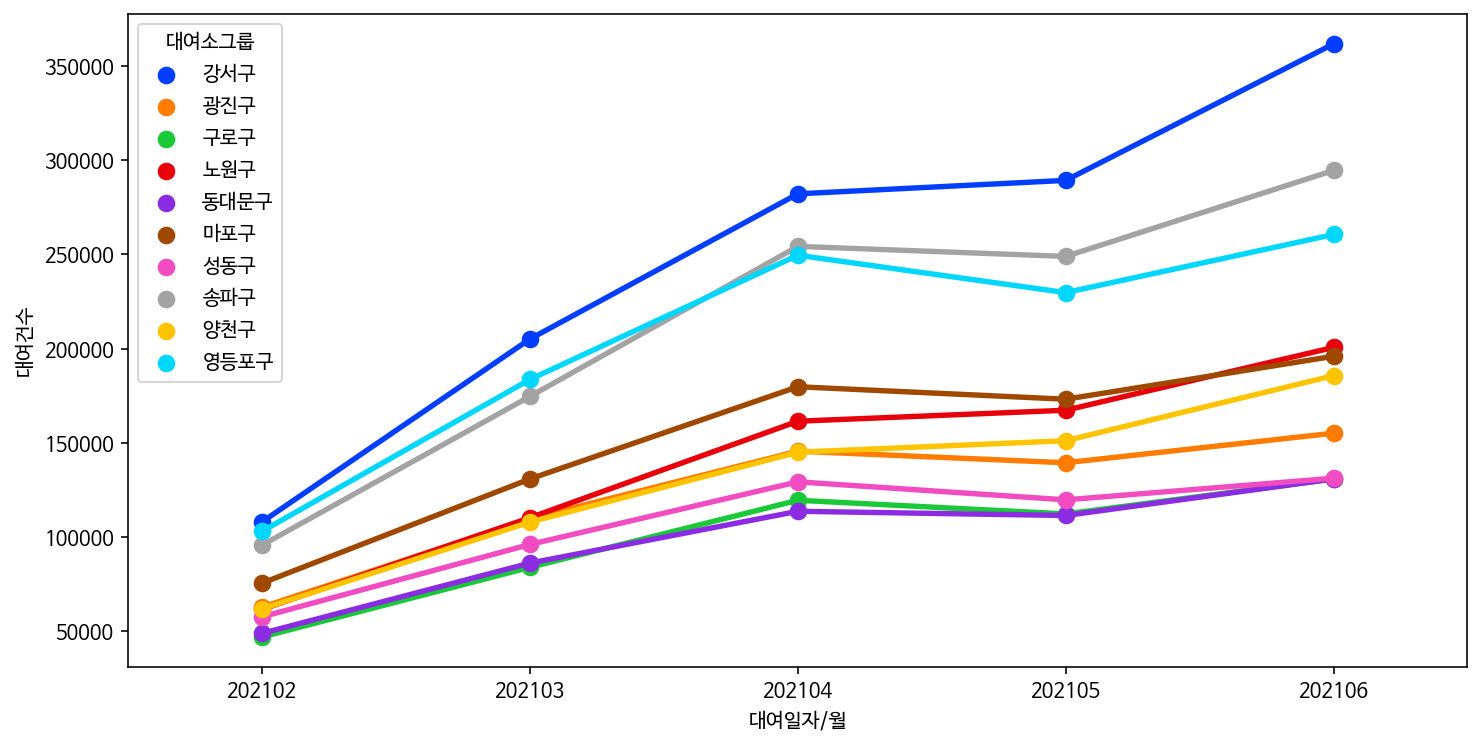

In [ ]:
plt.figure(figsize=(12,6))
sns.pointplot(x=df['대여일자/월'], y=df['대여건수'], hue= df['대여소그룹'], palette='bright')

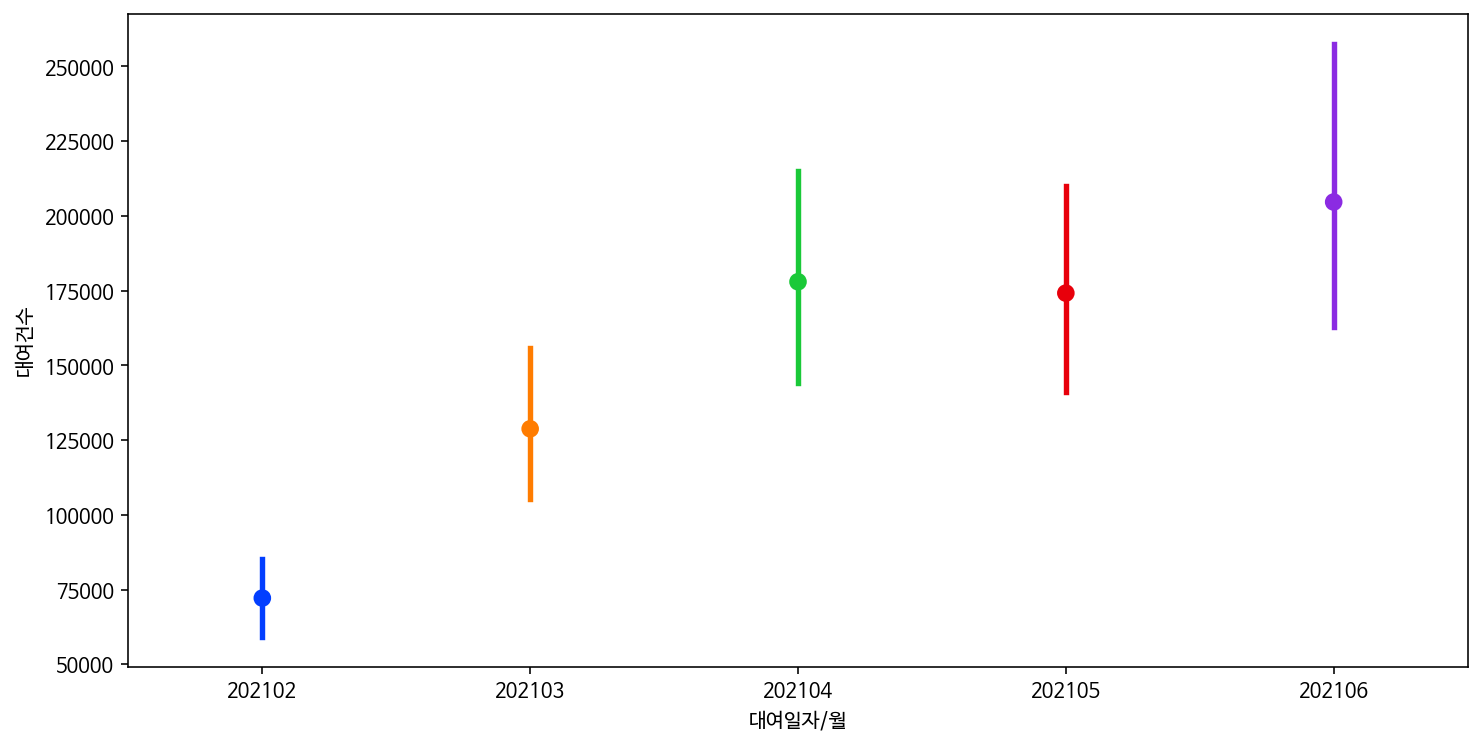

In [ ]:
plt.figure(figsize=(12,6))
sns.pointplot(x=df['대여일자/월'], y=df['대여건수'], palette='bright')

##4-4.평균이동거리가 많은 대여소 순

In [ ]:
bk_df3.head()

,대여일자,대여시간,대여소번호,대여소명,대여구분코드,성별,연령대코드,이용건수,운동량,탄소량,이동거리,사용시간,대여소명_new,년도,월,일,요일(num),요일
0,2021-06-01,0,2169,2169. 봉천역 2번출구,정기권,NaN,10대,1,8.75,0.08,350.53,3,봉천역 2번출구,2021,6,1,1,화
1,2021-06-01,0,1450,1450. 화랑대역 7번출구,정기권,NaN,10대,1,54.31,0.49,2110.00,14,화랑대역 7번출구,2021,6,1,1,화
2,2021-06-01,0,1282,1282. 송파소방서 맞은편(성내4교),정기권,NaN,10대,1,26.30,0.18,772.25,6,송파소방서 맞은편(성내4교),2021,6,1,1,화
3,2021-06-01,0,1288,1288. 문정중교 사거리,정기권,NaN,10대,1,27.50,0.30,1285.82,5,문정중교 사거리,2021,6,1,1,화
4,2021-06-01,0,1737,1737. 하나은행 (창동점),정기권,NaN,10대,1,42.46,0.46,1985.56,21,하나은행 (창동점),2021,6,1,1,화


In [ ]:
grp_dist = bk_df3.groupby('대여소명_new')[['이동거리']].mean().round(2)
grp_dist = grp_dist.sort_values('이동거리', ascending=False).head(10)
grp_dist

,이동거리
대여소명_new,
강남세브란스교차로 래미안그레이튼 104동 앞,21340.23
독산보도육교 앞 자전거 보관소,9823.32
석수역1번출구 앞 (SK주유소),9202.94
흑석역 1번출구,8995.98
옥수역 3번출구,8981.35
여의나루역 1번출구 앞,8979.78
당산육갑문,8749.53
압구정나들목,8706.39
동작역 5번출구 동작주차공원,8388.85


##4-5.평균사용시간이 많은 대여소 순

In [ ]:
# grp_dist = bk_df3.groupby('대여소명_new')[['이동거리']].mean().round(2)
# grp_dist = grp_dist.sort_values('이동거리', ascending=False).head(10)
# grp_dist

grp_time = bk_df3.groupby('대여소명_new')[['사용시간']].mean().round(2)
grp_time = grp_time.sort_values('사용시간', ascending=False).head(10) 
grp_time

,사용시간
대여소명_new,
여의나루역 1번출구 앞,70.28
마포구민체육센터 앞,64.59
뚝섬유원지역 1번출구 앞,62.53
현대고등학교 건너편,62.40
동작역 5번출구 동작주차공원,62.39
당산육갑문,61.88
여의도중학교 옆,61.17
서울숲 관리사무소,60.73
서울숲 공영주차장앞,60.07


## 4-6.요일별 이용건수 시각화


In [ ]:
grp_day = bk_df3.groupby(['요일','연령대코드'])[['사용시간']].mean().round(1)
grp_day =  grp_day.reset_index()
grp_day


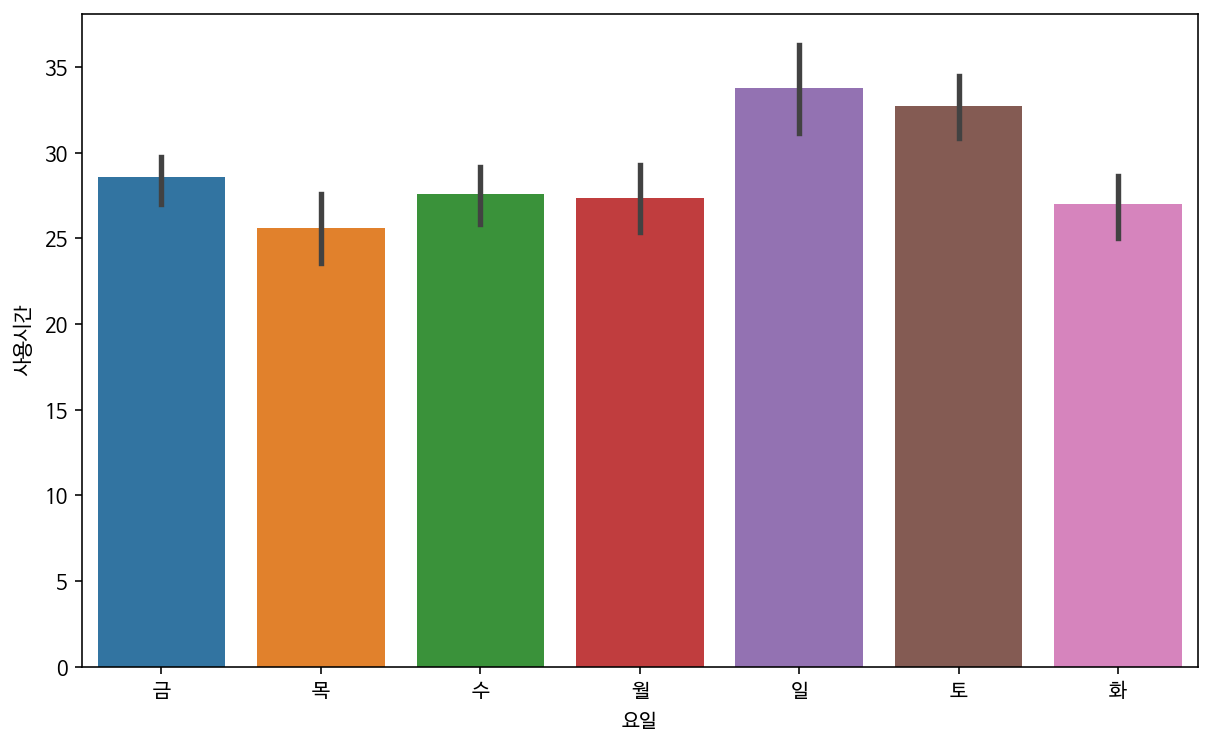

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data =grp_day, x= '요일', y= '사용시간')

<Figure size 720x432 with 0 Axes>

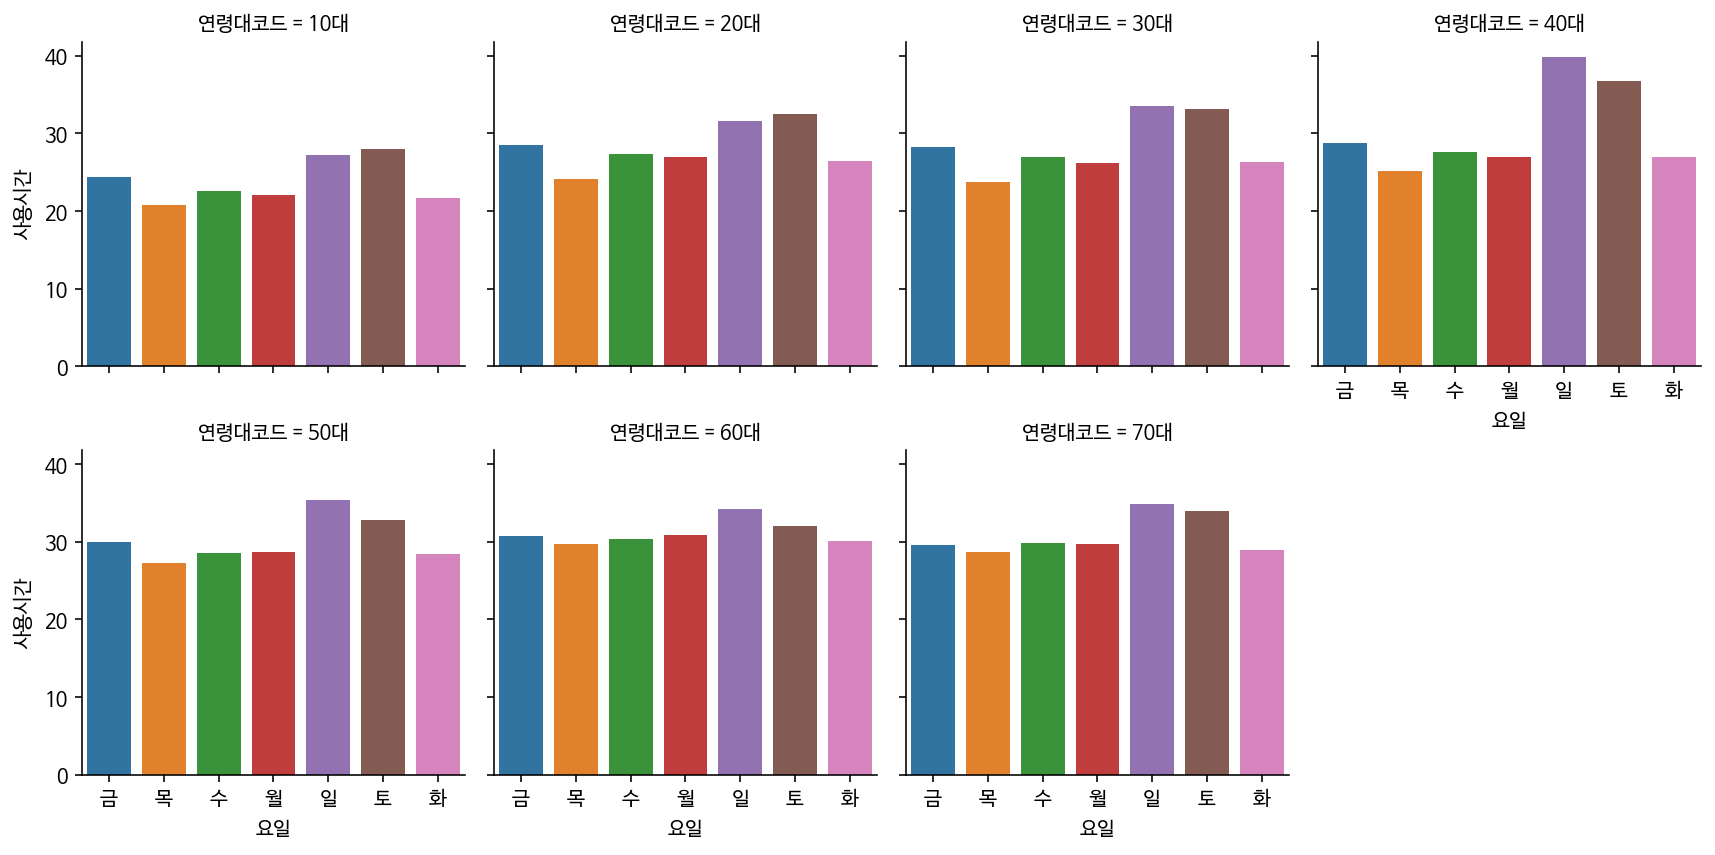

In [ ]:
plt.figure(figsize=(10,6))
sns.catplot(data = grp_day, x= '요일', y= '사용시간', col='연령대코드', kind='bar', #-> point
            col_wrap=4, height=3)
# catplot : 범주형 변수에 대해 서브플롯을 그려줌
# Categorical plots를 모두 그릴 수 있음
# kind 파라미터로 설정 가능 --> strip(기본값), swarm, box, violin, boxen, point, bar, count  

##4-6.구별 거치대 개수 지도로 나타내기

In [ ]:
bk_df1.head()

,대여소번호,대여소명,자치구,상세주소,위도,경도,설치시기,거치대수lcd,거치대수qr,운영방식
0,102,망원역 1번출구 앞,마포구,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06,20.0,0.0,LCD
1,103,망원역 2번출구 앞,마포구,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06,14.0,0.0,LCD
2,104,합정역 1번출구 앞,마포구,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06,13.0,0.0,LCD
3,105,합정역 5번출구 앞,마포구,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06,5.0,0.0,LCD
4,106,합정역 7번출구 앞,마포구,서울특별시 마포구 독막로 4,37.548645,126.912826,2015-09-06,10.0,0.0,LCD


In [ ]:
# lcd+qr인 컬럼생성
bk_df1['총거치대수']= bk_df1['거치대수lcd'] + bk_df1['거치대수qr']
bk_df1.head()

In [ ]:
bk_df1_gu_sum = bk_df1.groupby("자치구").agg({'총거치대수':'sum','경도':'mean', '위도':'mean'})
bk_df1_gu_sum = bk_df1_gu_sum.reset_index()  # json파일의 구와 내용을 연결해주려면 index명이 구가 되어야함
bk_df1_gu_sum.head()

,자치구,총거치대수,경도,위도
0,강남구,1711.0,127.057637,37.498893
1,강동구,1430.0,127.147696,37.547434
2,강북구,679.0,127.026329,37.632774
3,강서구,2137.0,126.836185,37.558614
4,관악구,862.0,126.939965,37.479601


In [ ]:
bk_df1_gu_sum = bk_df1_gu_sum.set_index('자치구')

In [ ]:
bk_df1_gu_sum

,총거치대수,경도,위도
자치구,,,
강남구,1711.0,127.057637,37.498893
강동구,1430.0,127.147696,37.547434
강북구,679.0,127.026329,37.632774
강서구,2137.0,126.836185,37.558614
관악구,862.0,126.939965,37.479601
광진구,1115.0,127.081612,37.545527
구로구,1234.0,126.861033,37.492431
금천구,765.0,126.896810,37.468824
노원구,1445.0,125.999678,37.329624


In [ ]:
import folium
import json

# 서울 행정구역 json raw파일
geo_path = '/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/데이터분석/data_mj/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [ ]:
# 서울지역 구별 boundary 시각화
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11)  # 위도,경도
bk_m

- 참고: https://towardsdatascience.com/how-to-step-up-your-folium-choropleth-map-skills-17cf6de7c6fe

In [ ]:
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11)


bk_m.choropleth(    # 단계구분도 
    geo_data = geo_str,       # json geometry
    data = bk_df1_gu_sum['총거치대수'], # GeoJSON 에 bind할 데이터
    columns =['자치구','총거치대수'],    # col1 = key, col2 = value
    fill_color = 'YlGnBu',   #색상변경
    key_on = 'feature.properties.name',  # json geometry에서 bind할 데이터
    legend_name = '거치대수'
)
bk_m

In [ ]:
bk_df1_gu_sum = bk_df1_gu_sum.reset_index()
bk_df1_gu_sum

In [ ]:
# 지도에 서클 그림
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11.5)
folium.Choropleth(
    geo_data = geo_str,
    data = bk_df1_gu_sum,
    columns =['자치구','총거치대수'],
    fill_color = 'YlGnBu',
    fill_opacity=0.6,
    line_opacity=0.3,
    key_on = 'feature.properties.name',
    legend_name = '거치대수'
).add_to(bk_m)

for i in bk_df1_gu_sum.index:   
    bk_lat = bk_df1_gu_sum.loc[i, "위도"]
    bk_long = bk_df1_gu_sum.loc[i, "경도"]
    gu = bk_df1_gu_sum.loc[i,'자치구']
    cnt = bk_df1_gu_sum.loc[i,'총거치대수']
    # 원의 반지름
    if cnt > 2000 :
        radius = 50
    elif cnt > 1000:
        radius = 35
    elif cnt > 500:
        radius = 20
    else:
        radius = 10
    # 마우스 갖다댔을 때
    title = f'{gu} : {cnt}'
    #radius = np.sqrt(cnt)

    folium.CircleMarker(
        [bk_lat,bk_long ], 
        radius=radius,
        fill = True,
        color='blue', 
        tooltip=title).add_to(bk_m)
bk_m

In [ ]:
# [추가질문]
# - 운동량과 이동거리의 상관관계?
# - 따릉이를 가장 많이 이용하는 성별은?
# - 따릉이를 가장 많이 이용하는 연령대는?

In [177]:
bk_df3.corr()

,대여시간,이용건수,운동량,탄소량,이동거리,사용시간,년도,월,일,요일(num)
대여시간,1.000000,0.072309,0.000805,0.087754,0.088047,0.114186,NaN,NaN,0.004790,0.005721
이용건수,0.072309,1.000000,-0.000338,0.242517,0.242381,0.316045,NaN,NaN,-0.003102,-0.009678
운동량,0.000805,-0.000338,1.000000,0.004107,0.004117,0.002281,NaN,NaN,0.000399,0.001184
탄소량,0.087754,0.242517,0.004107,1.000000,0.998242,0.572631,NaN,NaN,-0.012497,0.041571
이동거리,0.088047,0.242381,0.004117,0.998242,1.000000,0.577890,NaN,NaN,-0.012778,0.041755
사용시간,0.114186,0.316045,0.002281,0.572631,0.577890,1.000000,NaN,NaN,-0.013170,0.070550
년도,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
월,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
일,0.004790,-0.003102,0.000399,-0.012497,-0.012778,-0.013170,NaN,NaN,1.000000,-0.037824
요일(num),0.005721,-0.009678,0.001184,0.041571,0.041755,0.070550,NaN,NaN,-0.037824,1.000000


In [178]:
bk_df3.describe().round()

,대여시간,이용건수,운동량,탄소량,이동거리,사용시간,년도,월,일,요일(num)
count,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0,2616598.0
mean,15.0,1.0,388.0,1.0,3365.0,28.0,2021.0,6.0,16.0,3.0
std,6.0,0.0,167156.0,1.0,5222.0,33.0,0.0,0.0,9.0,2.0
min,0.0,1.0,-1.0,-1.0,0.0,0.0,2021.0,6.0,1.0,0.0
25%,10.0,1.0,24.0,0.0,940.0,8.0,2021.0,6.0,8.0,1.0
50%,16.0,1.0,49.0,0.0,1890.0,16.0,2021.0,6.0,16.0,3.0
75%,19.0,1.0,105.0,1.0,4018.0,38.0,2021.0,6.0,23.0,5.0
max,23.0,20.0,100000000.0,1098.0,4731984.0,1527.0,2021.0,6.0,30.0,6.0


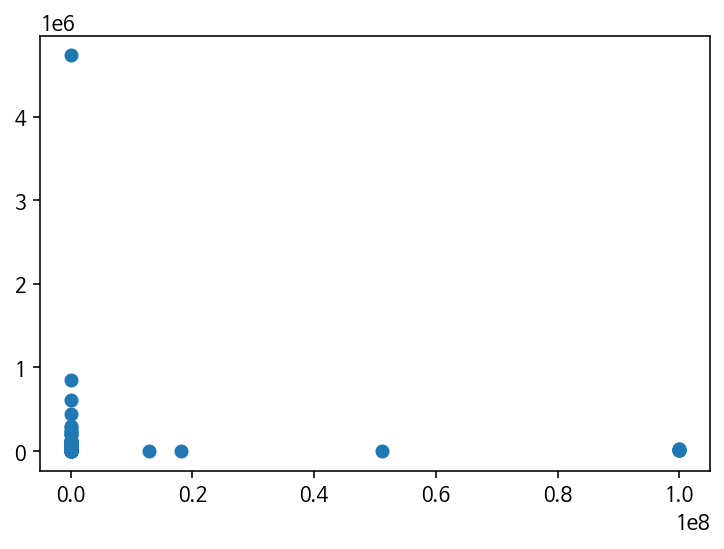

In [180]:
plt.scatter(bk_df3['운동량'], bk_df3['이동거리'])
plt.show()

# [전체 소스]

### 2-2. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import warnings
warnings.filterwarnings("ignore")

# 2-2. 데이터 불러오기
bk_df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/데이터분석/data_mj/공공자전거 대여소 정보(21.06월 기준).csv', encoding='cp949')
bk_df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/데이터분석/data_mj/공공자전거 대여소별 이용정보_21.02_21.06.csv' ,encoding='cp949')
bk_df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/데이터분석/data_mj/공공자전거 이용정보(시간대별)_21.06.csv',encoding='cp949')

### 3-2. 대여소 정보 (bk_df1)

In [ ]:
# 3-2-1. 결측치 처리
bk_df1['거치대수lcd'] = bk_df1['거치대수lcd'].fillna(0)
bk_df1['거치대수qr'] = bk_df1['거치대수qr'].fillna(0)
# 3-2-2 대여소번호 변환
bk_df1['대여소번호'] = bk_df1['대여소번호'].astype(object)

### 3-3. 대여소별 이용정보(월별)(bk_df2)

In [ ]:
# 3-3. 대여소별 이용정보(월별)(bk_df2)
# 3-3-1. 결측치 처리
bk_df2 = bk_df2.dropna(how='all')

# 3-3-2. 대여소번호와 대여소명 분리하기
bk_df2['대여소번호'] = bk_df2['대여소 명'].str.split(".", expand=True)[0]
bk_df2['대여소명_new'] = bk_df2['대여소 명'].str.split(".",expand=True)[1]

bk_df2 = bk_df2.dropna(subset=['대여소명_new'])

# 3-3-3. 컬럼명 변경
bk_df2.columns = ['대여소그룹','대여소명','대여일자/월','대여건수','대여소번호','대여소명_new']

# 3-3-4. 대여일자/월 변환
bk_df2['대여일자/월'] = bk_df2['대여일자/월'].astype(str)
bk_df2['대여일자/월'] = bk_df2['대여일자/월'].str[:6]


### 3-4. 시간대별 이용정보 (bk_df3)

In [ ]:
#3-4-1. 결측치 처리

bk_df3.loc[bk_df3['성별']=='f','성별'] = 'F'
bk_df3.loc[bk_df3['성별']=='m','성별'] = 'M'

# 3-4-2. 이상치 확인
# IQR 활용한 이상치 함수 구현
def outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return data[(data > upper_bound) | (data < lower_bound)].index

outliers = outliers_iqr(bk_df3['이동거리'])
bk_df4 = bk_df3.drop(outliers)

# 3-4-3. 연령대코드 처리
bk_df3.loc[bk_df3['연령대코드'] == '~10대','연령대코드'] = '10대'
bk_df3.loc[bk_df3['연령대코드'] == '70대~','연령대코드'] = '70대'

# 3-4-4. 대여소번호와 대여소명 분리하기

bk_df3['대여소명_new'] = bk_df3['대여소명'].str.split(".",expand=True)[1]

# 3-4-5. 데이터타입 변환
bk_df3['대여소번호'] = bk_df3['대여소번호'].astype(object)

bk_df3['대여일자'] = pd.to_datetime(bk_df3['대여일자'])
bk_df3['년도'] = bk_df3['대여일자'].dt.year
bk_df3['월'] = bk_df3['대여일자'].dt.month
bk_df3['일'] = bk_df3['대여일자'].dt.day
bk_df3['요일(num)']=bk_df3['대여일자'].dt.dayofweek

weekday_map= {0:'월', 1:'화', 2:'수', 3:'목',
              4:'금', 5:'토', 6:'일'}
bk_df3['요일'] = bk_df3['요일(num)'].map(weekday_map)

# ctl + / 여러개 주석 처리 

# bk_df3.loc[bk_df3['운동량']== '\\N','운동량'] = -1
# bk_df3.loc[bk_df3['탄소량']== '\\N','탄소량'] = -1
# bk_df3['운동량'] = pd.to_numeric(bk_df3['운동량'])
# bk_df3['탄소량'] = pd.to_numeric(bk_df3['탄소량'])

## 4.EDA & Visualization

### 4-1.대여소그룹별 대여건수

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

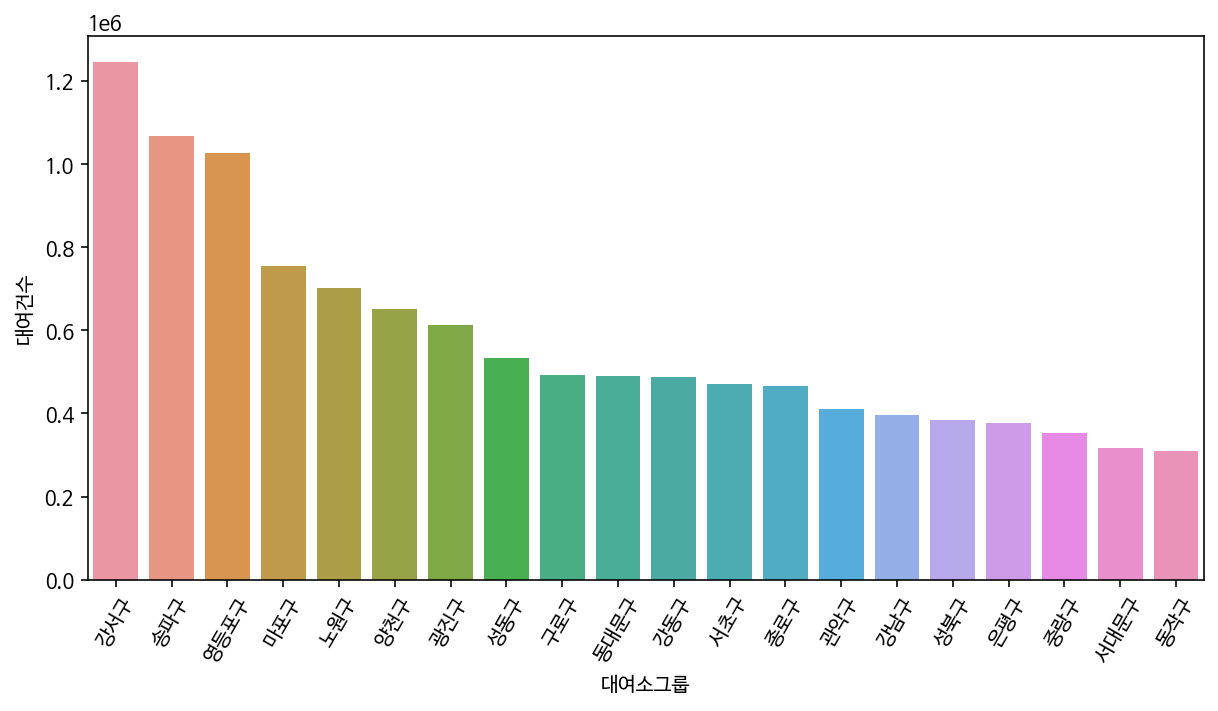

In [ ]:
# 대여소 그룹별 대여건수의 합
df = bk_df2.groupby('대여소그룹')['대여건수'].sum()
df = df.reset_index()
df = df.reset_index().sort_values(by='대여건수', ascending=False)[:20]
gu_lst = df['대여소그룹'][:10]
gu_lst = list(gu_lst.values)
plt.figure(figsize=(10,5))
sns.barplot(x= df['대여소그룹'], y=df['대여건수'])
plt.xticks(rotation = 60)

### 4-2.대여건수가 많은 상위 대여소

In [ ]:
df = bk_df2.groupby('대여소명_new')[['대여건수']].sum()
df = df.reset_index().sort_values(by='대여건수', ascending=False)[:20]
plt.figure(figsize=(12,8))
sns.barplot(x=df['대여건수'] , y= df['대여소명_new'])
plt.yticks(fontsize=12)

### 4-3.월별,대여소그룹별 대여건수

In [ ]:
df = bk_df2.groupby(['대여일자/월','대여소그룹'])[['대여건수']].sum()
df = df.reset_index()
df = df.loc[df['대여소그룹'].isin(gu_lst)]
plt.figure(figsize=(12,6))
sns.pointplot(x=df['대여일자/월'], y=df['대여건수'], hue= df['대여소그룹'], palette='bright')

### 4-4.평균이동거리가 많은 대여소 순

In [ ]:
grp_dist = bk_df3.groupby('대여소명_new')[['이동거리']].mean().round(2)
grp_dist = grp_dist.sort_values('이동거리', ascending=False).head(10)
grp_dist

### 4-5.평균사용시간이 많은 대여소 순

In [ ]:
grp_time = bk_df3.groupby('대여소명_new')[['사용시간']].mean().round(2)
grp_time =  grp_time.reset_index().sort_values('사용시간', ascending=False).head(10)
grp_time 

### 4-6.요일별 이용건수 시각화

In [ ]:
grp_day = bk_df3.groupby(['요일','연령대코드'])[['사용시간']].mean().round(1)
grp_day =  grp_day.reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data = grp_day, x= '요일', y= '사용시간')

In [ ]:
plt.figure(figsize=(10,6))
sns.catplot(data = grp_day, x= '요일', y= '사용시간', col='연령대코드', kind='bar', #-> point
            col_wrap=4, height=3)

### 4-6.구별 거치대 개수 지도로 나타내기

In [ ]:
bk_df1['총거치대수']= bk_df1['거치대수lcd'] + bk_df1['거치대수qr']
bk_df1_gu_sum = bk_df1.groupby("자치구").agg({'총거치대수':'sum','경도':'mean', '위도':'mean'})
bk_df1_gu_sum = bk_df1_gu_sum.reset_index()  # json파일의 구와 내용을 연결해주려면 index명이 구가 되어야함
bk_df1_gu_sum = bk_df1_gu_sum.set_index('자치구')
import folium
import json
# 서울 행정구역 json raw파일
geo_path = '/content/drive/MyDrive/Colab Notebooks/31 데이터역량강화/데이터분석/data_mj/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))
# 서울지역 구별 boundary 시각화
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11)  # 위도,경도
bk_m

In [ ]:
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11)


bk_m.choropleth(    # 단계구분도 
    geo_data = geo_str,       # json geometry
    data = bk_df1_gu_sum['총거치대수'], # GeoJSON 에 bind할 데이터
    columns =['자치구','총거치대수'],    # col1 = key, col2 = value
    fill_color = 'YlGnBu',   #색상변경
    key_on = 'feature.properties.name',  # json geometry에서 bind할 데이터
    legend_name = '거치대수'
)
bk_m

In [ ]:
bk_df1_gu_sum = bk_df1_gu_sum.reset_index()
bk_m = folium.Map(location=[37.5502, 126.982], zoom_start=11.5)
folium.Choropleth(
    geo_data = geo_str,
    data = bk_df1_gu_sum,
    columns =['자치구','총거치대수'],
    fill_color = 'YlGnBu',
    fill_opacity=0.6,
    line_opacity=0.3,
    key_on = 'feature.properties.name',
    legend_name = '거치대수'
).add_to(bk_m)

for i in bk_df1_gu_sum.index:   
    bk_lat = bk_df1_gu_sum.loc[i, "위도"]
    bk_long = bk_df1_gu_sum.loc[i, "경도"]
    gu = bk_df1_gu_sum.loc[i,'자치구']
    cnt = bk_df1_gu_sum.loc[i,'총거치대수']
    # 원의 반지름
    if cnt > 2000 :
        radius = 50
    elif cnt > 1000:
        radius = 35
    elif cnt > 500:
        radius = 20
    else:
        radius = 10
    # 마우스 갖다댔을 때
    title = f'{gu} : {cnt}'
    #radius = np.sqrt(cnt)

    folium.CircleMarker(
        [bk_lat,bk_long ], 
        radius=radius,
        fill = True,
        color='blue', 
        tooltip=title).add_to(bk_m)
bk_m